In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))



In [2]:
from data.dataset import CoDeTM4


/home/bosa/diplomska/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
train, val, test  = CoDeTM4('../../data/').get_dataset(['train','val','test'], columns='all', dynamic_split_sizing=False)


In [4]:
from datasets import concatenate_datasets


In [5]:
codet = concatenate_datasets([train, val, test])


In [6]:
import tree_sitter_python as tspython
import tree_sitter_cpp as tscpp
import tree_sitter_java as tsjava
from tree_sitter import Parser, Language

TS_PYTHON = Language(tspython.language())
TS_JAVA = Language(tsjava.language())
TS_CPP = Language(tscpp.language())

PYTHON_PARSER, JAVA_PARSER, CPP_PARSER = Parser(language=TS_PYTHON), Parser(language=TS_JAVA), Parser(language=TS_CPP)

# Enable comment parsing by setting `parser.set_included_ranges` with full range of the source code
# This is a workaround: tree-sitter parsers by default include comments as nodes, 
# so no extra flag is needed, but if previously you filtered comments, do not filter now.


In [7]:
import matplotlib.pyplot as plt


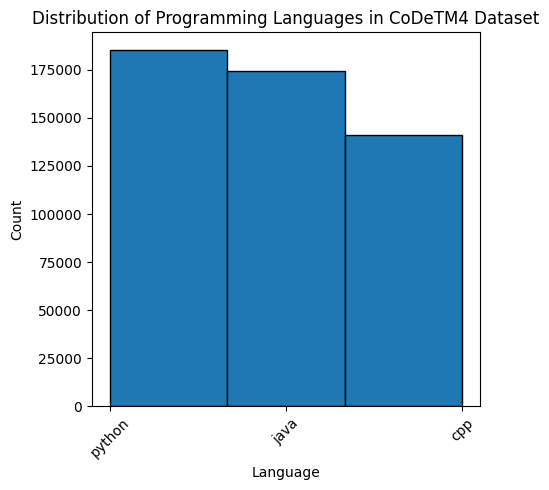

Python count: 185163
Java count: 174169
C++ count: 141220


In [8]:
language_counts = codet['language']
plt.figure(figsize=(5, 5))
plt.hist(language_counts, bins=len(set(language_counts)), edgecolor='black')
plt.xlabel('Language')
plt.ylabel('Count')
plt.title('Distribution of Programming Languages in CoDeTM4 Dataset')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

python_count = language_counts.count("python")
java_count = language_counts.count("java")
cpp_count = language_counts.count("cpp")

print(f'Python count: {python_count}')
print(f'Java count: {java_count}')
print(f'C++ count: {cpp_count}')


In [9]:
def get_parser(language):
    match language:
        case 'python':
            return PYTHON_PARSER
        case 'java':
            return JAVA_PARSER
        case 'cpp':
            return CPP_PARSER
    raise ValueError(f"Unsupported language: {language}")


In [10]:
def create_tree(sample, code_key='cleaned_code'):
    language = sample['language']
    parser = get_parser(language)
    # Include full range to keep comments included
    code_bytes = bytes(sample[code_key], 'utf-8')
    # Use full range
    #parser.set_included_ranges([ (0, len(code_bytes)) ])
    tree = parser.parse(code_bytes)
    # Reset included ranges to None after parse to avoid side effects
    #parser.set_included_ranges(None)
    return tree


In [11]:
from tree_sitter import TreeCursor

def walk_tree(cursor: TreeCursor, depth=0):
    indent = '  ' * depth
    print(f"{indent}{cursor.node.type}")

    if cursor.goto_first_child():
        walk_tree(cursor, depth+1)
    
        while cursor.goto_next_sibling():
            walk_tree(cursor, depth+1)

        cursor.goto_parent()


In [12]:
from typing import Set

def get_node_types_from_tree(cursor: TreeCursor, types: Set[str]=None) -> Set[str]:
    if types is None:
        types = set()
    
    types.add(cursor.node.type)

    if cursor.goto_first_child():
        get_node_types_from_tree(cursor, types)
    
        while cursor.goto_next_sibling():
            get_node_types_from_tree(cursor, types)

        cursor.goto_parent()

    return types


In [13]:
def extract_types(sample):
    # Import everything needed inside the function
    import tree_sitter_python as tspython
    import tree_sitter_cpp as tscpp
    import tree_sitter_java as tsjava
    from tree_sitter import Parser, Language, TreeCursor
    from typing import Set
    
    # Create parsers locally
    TS_PYTHON = Language(tspython.language())
    TS_JAVA = Language(tsjava.language())
    TS_CPP = Language(tscpp.language())
    
    PYTHON_PARSER = Parser(language=TS_PYTHON)
    JAVA_PARSER = Parser(language=TS_JAVA)
    CPP_PARSER = Parser(language=TS_CPP)
    
    def get_parser(language):
        match language:
            case 'python':
                return PYTHON_PARSER
            case 'java':
                return JAVA_PARSER
            case 'cpp':
                return CPP_PARSER
        raise ValueError(f"Unsupported language: {language}")
    
    def get_node_types_from_tree(cursor: TreeCursor, types: Set[str]=None) -> Set[str]:
        if types is None:
            types = set()
        
        types.add(cursor.node.type)

        if cursor.goto_first_child():
            get_node_types_from_tree(cursor, types)
        
            while cursor.goto_next_sibling():
                get_node_types_from_tree(cursor, types)

            cursor.goto_parent()

        return types
    
    parser = get_parser(sample['language'])
    code_bytes = sample['code'].encode('utf-8')
    # parser.set_included_ranges([ (0, len(code_bytes)) ])
    tree = parser.parse(code_bytes)
    # parser.set_included_ranges(None)
    cursor = tree.walk()
    types = get_node_types_from_tree(cursor)
    return {"types": list(types)}

result = codet.map(extract_types, batched=False, num_proc=8)

all_types = set()
for tlist in result['types']:
    all_types.update(tlist)

print(f"Collected {len(all_types)} unique node types")


Collected 565 unique node types


In [14]:
all_types = sorted(list(all_types))


In [15]:
type_to_ind = {t: i for i, t in enumerate(all_types)}


In [16]:
len(all_types)

565

In [17]:
for t in all_types:
    print(t)



!
!=
"
""
#define
#elif
#else
#endif
#if
#ifdef
#ifndef
#include
%
%=
&
&&
&=
'
(
()
)
*
**
**=
*=
+
++
+=
,
-
--
-=
->
.
.*
...
/
//
//=
/=
:
::
:=
;
<
<<
<<=
<=
<=>
<>
=
==
>
>=
>>
>>=
>>>
>>>=
?
@
@interface
ERROR
L"
L'
NULL
R"
U"
[
[[
[]
\
]
]]
^
^=
_
__asm
__asm__
__attribute
__attribute__
__future__
__inline
__restrict__
__volatile__
abstract
abstract_array_declarator
abstract_function_declarator
abstract_parenthesized_declarator
abstract_pointer_declarator
abstract_reference_declarator
access_specifier
alias_declaration
aliased_import
alignas
alignas_qualifier
alignof
alignof_expression
and
annotated_type
annotation
annotation_argument_list
annotation_type_body
annotation_type_declaration
annotation_type_element_declaration
argument_list
array_access
array_creation_expression
array_declarator
array_initializer
array_type
as
as_pattern
as_pattern_target
asm
assert
assert_statement
assignment
assignment_expression
asterisk
async
attribute
attribute_declaration
attribute_specifie

In [18]:
from torch_geometric.data import Data
from typing import List, Tuple, Dict
from tree_sitter import Node


In [19]:
from torch_geometric.data import Data
from typing import List, Tuple, Dict
from torch import tensor, long as tlong
from tree_sitter import TreeCursor

def tree_to_graph(cursor: TreeCursor, id_map: Dict = None, next_id: int = 0, edges: List[Tuple[int, int]] = None) -> Tuple[List[Tuple[int, int]], Dict, int]:
    if edges is None:
        edges = []
    if id_map is None:
        id_map = {}

    # Assign ID to current node
    if cursor.node not in id_map:
        id_map[cursor.node] = next_id
        next_id += 1
    current_id = id_map[cursor.node]

    if cursor.goto_first_child():
        # Process first child
        if cursor.node not in id_map:
            id_map[cursor.node] = next_id
            next_id += 1
        child_id = id_map[cursor.node]
        edges.append((current_id, child_id))
        edges, id_map, next_id = tree_to_graph(cursor, id_map, next_id, edges)
        
        # Process siblings
        while cursor.goto_next_sibling():
            if cursor.node not in id_map:
                id_map[cursor.node] = next_id
                next_id += 1
            child_id = id_map[cursor.node]
            edges.append((current_id, child_id))
            edges, id_map, next_id = tree_to_graph(cursor, id_map, next_id, edges)
        
        cursor.goto_parent()

    return edges, id_map, next_id


In [20]:
from tqdm import tqdm


In [21]:
def create_graph(sample, code_key='cleaned_code'):
    tree = create_tree(sample, code_key=code_key)
    edges, id_map, _ = tree_to_graph(tree.walk())
    edge_index = tensor(edges, dtype=tlong).t().contiguous()
    x = [type_to_ind[node.type] for node, _ in sorted(id_map.items(), key=lambda kv: kv[1])]
    x = tensor(x, dtype=tlong)
    y = tensor([sample['target_binary']], dtype=tlong)

    graph_features = tensor(list(sample['features'].values()))
    
    metadata = {
        'language': sample['language'],
        'target': sample['target'],
        'target_binary': sample['target_binary'],
        'code': sample['code'],
        'cleaned_code': sample['cleaned_code']
    }
    
    data = Data(
        x=x, 
        y=y, 
        edge_index=edge_index, 
        graph_features=graph_features,
        metadata=metadata
    )    
    return data



In [22]:
codet


Dataset({
    features: ['code', 'language', 'model', 'split', 'target', 'source', 'features', 'cleaned_code', '__index_level_0__', 'target_binary'],
    num_rows: 500552
})

In [23]:
from torch_geometric.data import Data
from torch import tensor, long as tlong
from typing import List, Dict, Tuple
from collections import defaultdict, deque
import torch
def compute_depths(num_nodes: int, edges: List[Tuple[int, int]]) -> tlong:
    """Compute depth (distance from root) for each node."""
    depths = torch.zeros(num_nodes, dtype=torch.long)
    tree = defaultdict(list)
    for parent, child in edges:
        tree[parent].append(child)
    visited = [False] * num_nodes
    queue = deque([0])  # assume root node has ID 0
    visited[0] = True
    while queue:
        node = queue.popleft()
        for child in tree[node]:
            if not visited[child]:
                depths[child] = depths[node] + 1
                visited[child] = True
                queue.append(child)
    return depths

def compute_child_indices(num_nodes: int, edges: List[Tuple[int, int]]) -> tlong:
    """Compute sibling index for each node (order among its siblings)."""
    child_idx = torch.zeros(num_nodes, dtype=torch.long)
    tree = defaultdict(list)
    for parent, child in edges:
        tree[parent].append(child)
    for parent, children in tree.items():
        for i, child in enumerate(children):
            child_idx[child] = i
    return child_idx

def create_graph(sample, code_key='cleaned_code'):
    """Create a PyG Data object with node type, depth, and child index embeddings."""
    tree = create_tree(sample, code_key=code_key)
    edges, id_map, _ = tree_to_graph(tree.walk())
    
    edge_index = tensor(edges, dtype=tlong).t().contiguous()
    
    # Node type IDs
    x = [type_to_ind[node.type] for node, _ in sorted(id_map.items(), key=lambda kv: kv[1])]
    x = tensor(x, dtype=tlong)
    num_nodes = x.size(0)

    # Compute depth and child index
    node_depth = compute_depths(num_nodes, edges)
    child_index = compute_child_indices(num_nodes, edges)
    
    # Target
    y = tensor([sample['target_binary']], dtype=tlong)
    
    # Graph features
    graph_features = tensor(list(sample['features'].values()))
    
    # Metadata
    metadata = {
        'language': sample['language'],
        'target': sample['target'],
        'target_binary': sample['target_binary'],
        'code': sample['code'],
        'cleaned_code': sample['cleaned_code']
    }

    data = Data(
        x=x,
        y=y,
        edge_index=edge_index,
        node_depth=node_depth,
        child_index=child_index,
        graph_features=graph_features,
        metadata=metadata
    )
    
    return data


def create_graphs(dataset, desc_keyword, code_key='cleaned_code'):
    graphs = []

    for i, sample in enumerate(tqdm(dataset, desc=f'Creating {desc_keyword} graphs')):
        data = create_graph(sample, code_key)
        graphs.append(data)

    return graphs
    


In [ ]:
from torch_geometric.data import Data
from torch import save
import gc

train_graphs = create_graphs(train, 'train', 'code')
save(train_graphs, '../../data/codet_graphs/train_graphs_comments_depth.pt')
del train, train_graphs
gc.collect()
val_graphs = create_graphs(val, 'val', 'code')
save(val_graphs, '../../data/codet_graphs/val_graphs_comments_depth.pt')
del val, val_graphs
gc.collect()
test_graphs = create_graphs(test, 'test', 'code')
save(test_graphs, '../../data/codet_graphs/test_graphs_comments_depth.pt')
del test, test_graphs
gc.collect()
save(type_to_ind, '../../data/codet_graphs/type_to_ind_comments_depth.pt')


Creating train graphs: 100%|██████████| 405069/405069 [23:59<00:00, 281.35it/s] 


In [ ]:
from torch import load


In [ ]:
from torch_geometric.data import Data


/home/bosa/diplomska/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
train_graphs = load('../../data/codet_graphs/train_graphs_comments.pt', weights_only=False)


In [ ]:
type_to_ind = load('../../data/codet_graphs/type_to_ind_comments.pt', weights_only=False)


In [ ]:
len(train_graphs)


405069

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

def visualize_graph(data, figsize=(15, 10), show_labels=True):
    # Convert to NetworkX graph
    G = to_networkx(data, to_undirected=False)
    
    plt.figure(figsize=figsize)
    
    # Create tree layout manually
    pos = {}
    
    # Find root (node with no incoming edges)
    root = 0
    for node in G.nodes():
        if G.in_degree(node) == 0:
            root = node
            break
    
    # Assign positions level by level
    levels = {}
    queue = [(root, 0)]
    
    while queue:
        node, level = queue.pop(0)
        levels[node] = level
        
        # Add children to next level
        for child in G.successors(node):
            queue.append((child, level + 1))
    
    # Group nodes by level
    level_groups = {}
    for node, level in levels.items():
        if level not in level_groups:
            level_groups[level] = []
        level_groups[level].append(node)
    
    # Position nodes
    for level, nodes in level_groups.items():
        for i, node in enumerate(nodes):
            x = i - len(nodes) / 2  # Center nodes horizontally
            y = -level  # Higher levels at top
            pos[node] = (x, y)
    
    # Create labels if requested
    labels = None
    if show_labels:
        # Create reverse mapping from index to type
        ind_to_type = {v: k for k, v in type_to_ind.items()}
        labels = {}
        for node in G.nodes():
            node_type_idx = data.x[node].item()
            node_type = ind_to_type.get(node_type_idx, f"idx_{node_type_idx}")
            labels[node] = node_type
    
    nx.draw(G, pos, with_labels=show_labels, labels=labels, 
            node_color='lightblue', node_size=500, arrows=True, 
            font_size=6 if show_labels else 8)
    
    plt.title("AST Tree")
    plt.show()



In [ ]:
train_graphs[1]

Data(
  x=[48],
  edge_index=[2, 47],
  y=[1],
  graph_features=[8],
  metadata={
    language='python',
    target='human',
    target_binary=0,
    code='def reload(self):
        """Reload catalog if sufficient time has passed"""
        if time.time() - self.updated > self.ttl:
            self.force_reload()',
    cleaned_code='def reload(self):
        
        if time.time() - self.updated > self.ttl:
            self.force_reload()',
  }
)

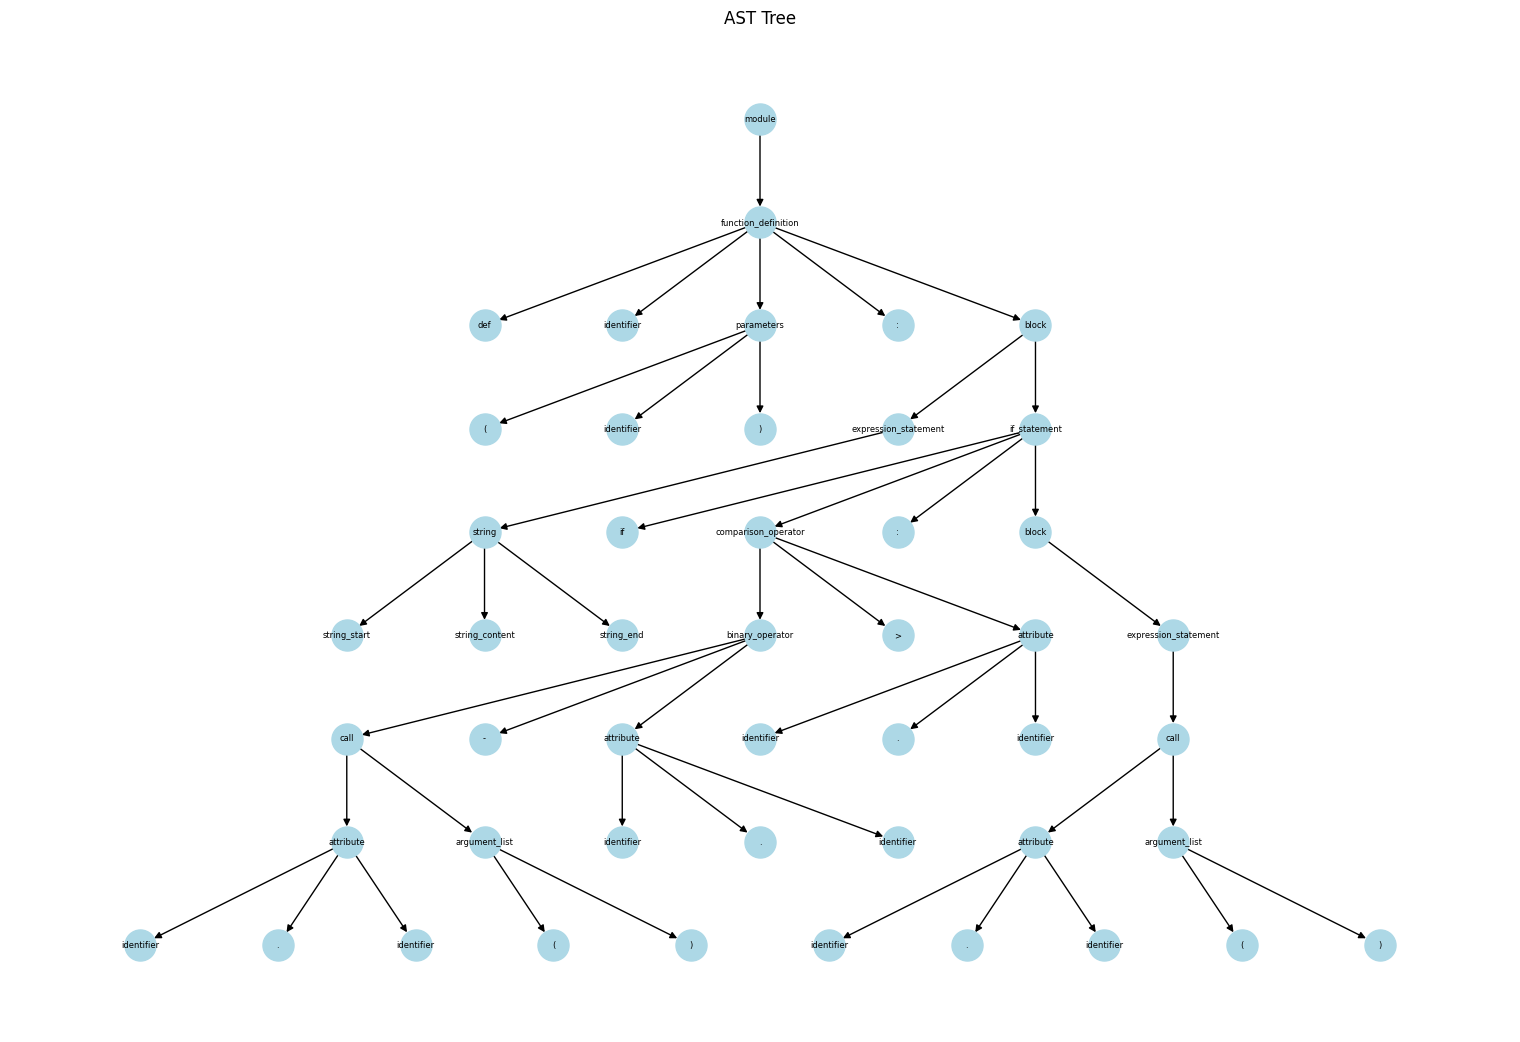

In [ ]:
visualize_graph(train_graphs[1], show_labels=True)
